# 1. **Define dependencies and constrains**

In order to download tweet from Twitter, first one must create an account and apply for **developer priviledges**. The application will grant the developer basic access the the [Twitter API](https://developer.twitter.com/en/docs/twitter-api) which are not enough because it only allows the download of tweet of the last 7 days. Therefore, I've applied to the [Premium plan](https://developer.twitter.com/en/support/twitter-api/premium) which allows the download of 25k of tweets per month along with the use _full archive_ and the _30 days_ search API but with limited amout of request per month.

In [1]:
COLAB_DIR = "/content/"

RANDOM_SEED = 42

# File with Twitter project credentials
CREDENTIALS = COLAB_DIR+'credentials.yaml'
CREDENTIALS_KEY = 'search_tweets_30_day_dev'

# csv file where tweet downloaded will be saved
DATASET = COLAB_DIR+'dataset.csv'
DATASET_ANNOTATED = COLAB_DIR+'dataset_annotated.csv'
SENTIPOLIC = COLAB_DIR+'sentipolic.csv'

# result of data processing
DATASET_PROCESSED = COLAB_DIR+"result_processed"
DRIVE_FOLDER = "/content/drive/MyDrive/BIG_DATA_MODELS/"

In [2]:
!python --version

Python 3.7.13


### install libraries

In [3]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=f1279043b0c6aa7ad37b07b88b65eee9443e615723d7fdfc8ebc91d2fd7b9b61
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [4]:
!apt-get install libenchant1c2a
!pip install pyenchant
!apt-get install hunspell-it

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,312 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [13.0 kB

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [6]:
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [8]:
!pip install pyspark==3.1.2
!pip install spark-nlp==3.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212.4 MB 65 kB/s 
     |████████████████████████████████| 198 kB 57.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=8706a05cb89640b0c9f4094e4377f7cfa8a0331c44ff895a585df6221efeb70e
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 15.2 MB/s 


In [9]:
!pip install sparktorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sparktorch: filename=sparktorch-0.1.2-py3-none-any.whl size=24596 sha256=d94b0e6aacf6a461187b5cde2976241f44c2e83e3eed29b4a15b52cc95733764
  Stored in directory: /root/.cache/pip/wheels/67/d4/a2/a288b918877e28698fc8ff8cb1d8290713bd84abcb80715d47
Successfully built sparktorch


In [10]:
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 2.2 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 


### PySpark configurations

In [11]:
# pyspark packages
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler, SQLTransformer, Normalizer
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace, transform

import sparknlp

In [12]:
import findspark
findspark.init()

In [13]:
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[4]")\
    .config('spark.executor.memory', '16G')\
    .config("spark.driver.memory","50G")\
    .config("spark.driver.cores", "10")\
    .config("spark.sql.analyzer.maxIterations", "6000")\
    .config("spark.driver.maxResultSize", "10G") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.4")\
    .getOrCreate()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.4
Apache Spark version: 3.1.2


In [14]:
sc = spark.sparkContext
type(sc)

pyspark.context.SparkContext

In [15]:
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

total 38952
-rw-r--r-- 1 root root 39885074 May  5 15:16 spark-nlp_2.12-3.4.4.jar


## Download useful files

In [16]:
!wget https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/dataset.csv
!wget https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/other/sentipolic.csv
!wget https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/credentials/credentials.yaml
!wget https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset_annotated.csv

--2022-05-30 21:38:52--  https://github.com/deborahdore/italian-sarcastic-tweet-classification/raw/main/dataset/dataset.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset.csv [following]
--2022-05-30 21:38:53--  https://raw.githubusercontent.com/deborahdore/italian-sarcastic-tweet-classification/main/dataset/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797205 (1.7M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   1.71M  --.-KB/s    in 0.02s   

2022-05-30 21:38:53 (81.

In [17]:
# italian dictionary for lemmatization
!wget https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-it.txt

--2022-05-30 21:38:55--  https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-it.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917510 (7.5M) [text/plain]
Saving to: ‘lemmatization-it.txt’

lemmatization-it.tx 100%[===================>]   7.55M  --.-KB/s    in 0.04s   

2022-05-30 21:38:55 (204 MB/s) - ‘lemmatization-it.txt’ saved [7917510/7917510]



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. **Retrieve Tweet**


> Following, some code cell will be annotated with *%% script false* in order to avoid their execution. Those cell concern the download of the tweets from Twitter. Even if this may not sound dangerous, I've finished the request at my disposal. Therefore, calling the Twitter API will produce an error. Also, please don't run them otherwise the output of the cell will be lost.



In [ ]:
# useful imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import json
import yaml
import csv
import pdb
import pandas as pd

- First we must retrieve and validate the credentials that we will need to access the Twitter API. I've store the bearer token in a yaml file: *credentials.yaml*





In [ ]:
def handle_credentials(credentials, key):
  with open(credentials, "r") as stream:
    try:
        credentials = yaml.safe_load(stream)
        return credentials[key]
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
credentials = handle_credentials(CREDENTIALS, CREDENTIALS_KEY)
endpoint = credentials['endpoint'] # we will use this endpoint to search for the tweet
print(endpoint)

https://api.twitter.com/1.1/tweets/search/30day/dev1.json


- Second we must create the header for the request

In [ ]:
def handle_headers(credentials:dict):
  headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {credentials["bearer_token"]}'
  }
  return headers

In [ ]:
headers = handle_headers(credentials)
headers

{'Authorization': 'Bearer None', 'Content-Type': 'application/json'}

- Another parameter of the request is the query. The query determines which tweet will be returned in the response. In our case, we have 2 types of queries: the one that searches for sarcastic tweets and the one that returns non-sarcastic tweets

For the query about sarcastic tweet I've chosen some keyword that, in my opion, are used to express sarcasm and/or irony (sarcasm is a sub-type of irony):


1. sarcasmo (with or without #)
2. ironia (with or without #)
3. "*ridiamo per non piangere*"
4. #coincidenze (.. io non credo) is mostly used to express sarcasm
5. "*qualquadra non cosa*"

Many studies also suggest that sarcasm can be found in tweet related to politics. Therefore, these seems very good starting point:
1. monti, draghi, berlusconi (known italian prime minister)
2. governo
3. premier


For non-sarcastic tweet, I've excluded all the possibile word that may refer to sarcasm.

The list of operator used can be found in the [Twitter API documentation](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product).

In [ ]:
sarcasm_query = '(#sarcasmo OR sarcasmo OR #ironia OR ironia OR "ridiamo per non piangere" \
                  OR #coincidenze OR "qualquadra non cosa" OR draghi OR monti OR berlusconi \
                  OR governo OR premier) lang:it -has:media'

non_sarcasm_query = '-"ridiamo per non piangere" -sarcasmo -ironia -"qualquadra non cosa" lang:it -has:media'

- Now we can define the function that will handle the request and the dataframe where tweet will be stored.


> Other parameters that we need in order to process the request are:
- *max_result_per_page* : the maximum number of tweets per call 
- *next_token* : a token that if passed to the request will return the next page of results
- I've defined a parameter *max_num_of_request* that will stop the call once that we've reached the desidered amount of calls. This must be done because the request at our disposal are not illimited. So we must be careful to the number of the request that we do




In [ ]:
def handle_request(endpoint, headers, query, max_result_per_page, next_token = None):
  
  if next_token is not None:
    payload = json.dumps({
      "maxResults": max_result_per_page,
      "query": query,
      "next": next_token
    })
  else:
    payload = json.dumps({
      "maxResults": max_result_per_page,
      "query": query,
    })
  
  response = requests.post(endpoint, headers=headers, data=payload)

  return response.text

In [ ]:
def extract_tweet(response, label):
  tweets = []
  json_response = json.loads(response)
  
  if 'results' in response:
    results = json_response["results"]

    for tweet in results:
      # is tweet a retweet?
      if 'retweeted_status' in tweet:
        if tweet['retweeted_status']['truncated']:
          text = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
          text = tweet['retweeted_status']['text']
      else:
        if tweet['truncated']:
          text = tweet['extended_tweet']['full_text']
        else:
          text = tweet['text']
        
      text = text.replace('"', "'")
      data = Tweet(tweet["id"], f"{text}", label)
      
      tweets.append(data)

  else:
    print("Request went wrong")
    print(response)

  return tweets

In [ ]:
def download_tweet(endpoint, 
                   headers, 
                   query, 
                   label,
                   max_result_per_page,
                   tweet_list,
                   next_token = None, 
                   max_num_of_request = 20):

  if max_num_of_request <= 0:
    return tweet_list

  response = handle_request(endpoint, headers, query, max_result_per_page, next_token)

  tweet_list.extend(extract_tweet(response, label))

  try:
      next_token = json.loads(response)['next']
  except:
      next_token = None

  if next_token is not None:
      return download_tweet(endpoint, headers, query, label, max_result_per_page,
                   tweet_list, next_token, max_num_of_request - 1)
  else:
      return tweet_list

In [ ]:
# define tweet
Tweet = Row("id", "text", "sarcastic")

In [ ]:
tweets = []

In [ ]:
%%script false

# download sarcastic tweet
tweets = download_tweet(endpoint, 
                   headers, 
                   sarcasm_query, 
                   "Yes",
                   100,
                   [],
                   next_token = None, 
                   max_num_of_request = 40)

In [ ]:
%%script false

# download non-sarcastic tweet
tweets.extend(
    download_tweet(endpoint, 
                   headers, 
                   non_sarcasm_query, 
                   "No",
                   100,
                   [],
                   next_token = None, 
                   max_num_of_request = 40))

In [ ]:
%%script false
# create DataFrame
df = spark.createDataFrame(tweets)

In [ ]:
%%script false
df.show(10, truncate=False)

In [ ]:
%%script false

# create file
if not os.path.exists(DATASET):
  os.mknod(DATASET)

# save tweets
df.toPandas().to_csv(DATASET, header=True, index=False) 

In [ ]:
%%script false
del df

# 3. **Annotate Tweet**

In [ ]:
# python widgets
from ipywidgets import Button
import asyncio
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox, Layout
import time as t

When we download tweet using an hashtag, we are not 100% sure of what we downloaded is correct. We must analyze - at least - the majority of the tweet to understand if what we have labelled is correct. There here's a little tool to help us with that.

In [ ]:
Tweet = Row("id", "text", "sarcastic")

schema = StructType([StructField("id", StringType(), True)\
                   ,StructField("text", StringType(), True)\
                   ,StructField("sarcastic", StringType(), True)])

df = spark.createDataFrame(pd.read_csv(DATASET), schema=schema)
df.show(10)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524034279151489025|@AlienoGentile C’...|       No|
|1524034279122034690|@NaremFox @RickyT...|       No|
|1524034278983704581|Sempre al fine di...|       No|
|1524034278870372354|E Comunque quest'...|       No|
|1524034278828425218|Comunque a me Alb...|       No|
|1524034278719475712|che bella persona...|       No|
|1524034278589411328|oddio io quando h...|       No|
|1524034278559993857|@carlopitocchi La...|       No|
|1524034278140616708|Oh nooo solo 400 ...|       No|
|1524034278031609856|@WillSorareSmith ...|       No|
+-------------------+--------------------+---------+
only showing top 10 rows



In [ ]:
def count_label(df, numeric=False):
  label_yes = 1 if numeric else "Yes"
  label_no = 0 if numeric else "No"
  return df.groupBy("sarcastic").agg(
      count(when(col("sarcastic") == label_yes, 1)),
      count(when(col("sarcastic") == label_no, 1)))

In [ ]:
# count tweet
print(f'Total number of tweet retrieved {df.count()}')

Total number of tweet retrieved 11800


In [ ]:
# we want first to drop duplicates

print("Count before drop:")
count_label(df).show()

count_before_drop = df.count()
df = df.dropDuplicates(["text"])
print(f"Distinct count: {str(df.count())} \n")

print("Count after drop:")
count_label(df).show()

Count before drop:
+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No|                                            0|                                        7800|
|      Yes|                                         4000|                                           0|
+---------+---------------------------------------------+--------------------------------------------+

Distinct count: 9290 

Count after drop:
+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No| 

In [ ]:
print(f'dropped {count_before_drop-df.count()} columns')
print(f'total count: {df.count()}')

dropped 2510 columns
total count: 9290


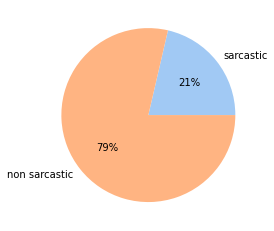

In [ ]:
# visually 
data = count_label(df).collect()

labels = ['sarcastic', 'non sarcastic']
colors = sns.color_palette('pastel')[0:5]

plt.pie([int(data[1][1]), int(data[0][2])], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
tweets_annotated = []

In [ ]:
def wait_for_change(widget1, widget2): 
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget1.on_click(getvalue, remove=True)
        widget2.on_click(getvalue, remove=True) 
    widget1.on_click(getvalue)
    widget2.on_click(getvalue)
    return future

async def f(df):
  df_pandas = df.toPandas()
  for index, row in df_pandas.iterrows():
    print(f'Is this tweet sarcastic? \n {row.text} \n', flush=True)

    x = await wait_for_change(sarcastic,non_sarcastic)
    
    if x == "Yes":
      print("Tagged ", row.id, "with sarcastic \n")
      data = Tweet(row.id, row.text, "Yes")
      tweets_annotated.append(data)
    else:
      print("Tagged ", row.id, "with non-sarcastic \n")
      data = Tweet(row.id, row.text, "No")      
      tweets_annotated.append(data)

    clear_output()
    display(HBox([sarcastic,non_sarcastic]))

Before going forward, we want to ask ourselves *How can know if a tweet is sarcastic or not?*

*In Harry Potter and the Half Blood Prince, there is a scene where Harry is leaving the Weasley house and Mrs. Weasley says: “Promise me you will look after yourself…stay out of trouble….” Harry responds: “I always do Mrs. Weasley. I like a quiet life, you know me.” Anyone familiar with Harry Potter knows that his life is far from quiet, and so he must not really mean what he is saying. In fact, Harry is being sarcastic.*

[source](https://kids.frontiersin.org/articles/10.3389/frym.2018.00056)

Sarcasm is the use of words that say the opposite of what you really mean, often as a joke and with a tone of voice that shows this. It is often used to mock or critize someone, express disapproval or as a defence mechanism.

For example:
> *Noi invece ce la caviamo con un grado in meno ai termosifoni d'inverno e spegnendo i condizionatori d'estate. Non è fantastico? (#Draghi è un cialtrone sesquipedale, nel caso aveste ancora qualche dubbio)*

Here we can imagine the sarcastic tone of the writer. He's obviously criticising the Italian prime minister, Mario Draghi, when, during an interview, he said that we must make sacrifices like lowering the grade of the radiator in order to cope with the possibility of not having the gas from Russia anymore. Obviously, this won't be enough. *Isn't this great?*

Sometimes it's difficult also for a human person to understand sarcasm therefore I don't expect the following dataset to be 100% free from bias.

In [ ]:
# tool used for annotation: it displays each tweet and the user has to click "Yes" 
# if the tweet was sarcastic, "No" otherwise

sarcastic=Button(description="Yes", button_style='info', layout=Layout(width='150px', height='50px'))
non_sarcastic=Button(description="No", button_style='info', layout=Layout(width='150px', height='50px'))

asyncio.create_task(f(df))
t.sleep(2)
display(HBox([sarcastic,non_sarcastic]))

In [ ]:
%%script false
print(tweets_annotated)

In [ ]:
%%script false
df_annotated = spark.createDataFrame(tweets_annotated)
df_annotated.tail(5)

In [ ]:
%%script false
if not os.path.exists(DATASET_ANNOTATED):
  os.mknod(DATASET_ANNOTATED)

# save tweets
df_annotated.toPandas().to_csv(DATASET_ANNOTATED, header=True, index=False)
del df_annotated

In [ ]:
del df

# 4. **Extend Dataset**

In [ ]:
schema = StructType([StructField("id", StringType(), True)\
                   ,StructField("text", StringType(), True)\
                   ,StructField("sarcastic", StringType(), True)])

df_annotated = spark.createDataFrame(pd.read_csv(DATASET_ANNOTATED), schema=schema)

In [ ]:
print(f"Annotated tweets: {df_annotated.count()}")

Annotated tweets: 5480


As we can see from the code below, we lost multiple *tweet*.
First of all, multiple tweets classified as sarcastic were not sarcastic. Also, I've dropped every tweet that contained only one word, that wasn't actually in italian or 
that had no sense.

In [ ]:
count_label(df_annotated).show()

+---------+---------------------------------------------+--------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = Yes) THEN 1 END)|count(CASE WHEN (sarcastic = No) THEN 1 END)|
+---------+---------------------------------------------+--------------------------------------------+
|       No|                                            0|                                        4629|
|      Yes|                                          830|                                           0|
|      NaN|                                            0|                                           0|
+---------+---------------------------------------------+--------------------------------------------+



However, we can integrate we some external Dataset such as: [SENTIPOLIC](http://www.di.unito.it/~tutreeb/sentipolc-evalita16/index.html) from the challenge EVALITA2016 which contains several italian tweet already classified.

In [ ]:
df_sentipolic = spark.createDataFrame(pd.read_csv(SENTIPOLIC))

In [ ]:
df_sentipolic.show(10)

+------------------+----+----+----+---+----+----+---+--------------------+
|         idtwitter|subj|opos|oneg|iro|lpos|lneg|top|                text|
+------------------+----+----+----+---+----+----+---+--------------------+
|122449983151669248|   1|   0|   1|  0|   0|   1|  1|Intanto la partit...|
|125485104863780865|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
|125513454315507712|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
|125524238290522113|   1|   0|   1|  0|   0|   1|  1|Mario Monti: Berl...|
|125527933224886272|   1|   0|   1|  0|   0|   1|  1|Mario Monti: Berl...|
|125530285164072961|   1|   1|   1|  0|   1|   1|  1|False illusioni, ...|
|125533343482789889|   1|   0|   1|  0|   0|   1|  1|L'attacco di Mari...|
|125633929217708032|   1|   1|   0|  0|   1|   0|  1|Mario Monti sul C...|
|125642756147265536|   1|   0|   1|  0|   0|   1|  1|Le 5 sgradevoli r...|
|125692702145785856|   1|   0|   1|  0|   0|   1|  1|False illusioni, ...|
+------------------+----+

In [ ]:
# we will extract only the tweets which are ironic since we have plenty non-ironic
df_sentipolic = df_sentipolic.filter(col("iro")==1)

In [ ]:
print(f"Ironic tweet retrieved: {df_sentipolic.count()}")

Ironic tweet retrieved: 1103


In [ ]:
df_sentipolic = df_sentipolic.withColumnRenamed("idTwitter", "id")\
                              .withColumnRenamed("iro", "sarcastic")\
                              .select("id", "text", "sarcastic")

In [ ]:
df_sentipolic.show(10)

+------------------+--------------------+---------+
|                id|                text|sarcastic|
+------------------+--------------------+---------+
|125695266887184384|Mario Monti: c'è ...|        1|
|125838624670490624|Ma a quanta gente...|        1|
|127137847491821568|#la7 ma perche' M...|        1|
|129143970163990528|Mario Monti è con...|        1|
|131426878245437440|Ma quanto ce vuol...|        1|
|133822129773879297|Mario Monti a cap...|        1|
|133831591234502656| Mario Monti for ...|        1|
|133849038243110912|[News] Mario Mont...|        1|
|133954931982991360|cmq Mario Monti è...|        1|
|134335814531416064| Napolitano: "Bis...|        1|
+------------------+--------------------+---------+
only showing top 10 rows



In [ ]:
# now we want to join the two dataset. However we must use the same label for both.
# Therefore if the tweet is sarcastic, the label will be 1, 0 otherwise.


df_annotated = df_annotated.withColumn("sarcastic", 
                                         when(df_annotated.sarcastic == "Yes", 1)
                                         .when(df_annotated.sarcastic == "No", 0)                                    
                                         .otherwise(df_annotated.sarcastic))

In [ ]:
df_annotated.show()

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'Tu sei un gioca...|        0|
|1524034020417294337|#10maggio In occa...|        0|
|1524034242963034112|#9maggio Zelensky...|        0|
|1524034526908981250|#A SCUOLA DI GIUS...|        1|
|1524034207923814401|#A1 - Ginevra -&g...|        0|
|1524034530579030018|#A1 - Zurigo -&gt...|        0|
|1524034404850581504|#APRILIA: TENTATO...|        0|
|1524034635012968448|#Agricoltura, Ocm...|        0|
|1524034097424777216|#Algeria: colloqu...|        0|
|1524034794635603972|#Alpini pensate c...|        1|
|1524034897383505921|#Amici21
Il mondo...|        0|
|1524034689366953984|#Amici21
Riassunt...|        0|
|1524034761940946952|#Amici21 che tene...|        0|
|1523988570867961856|#Armi #Ucraina Fr...|        1|
|1524001659290017794|#Armi, #gas e nuo...|        1|
|1524033774102720512|#Aron è una creat...|    

In [ ]:
# concatenate DataFrames
df_complete = df_annotated.union(df_sentipolic)

In [ ]:
df_complete.cache()
print(f'Now we have a total of {df_complete.count()} tweets')

Now we have a total of 6583 tweets


In [ ]:
df_complete.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|#'Tu sei un gioca...|        0|
|1524034020417294337|#10maggio In occa...|        0|
|1524034242963034112|#9maggio Zelensky...|        0|
|1524034526908981250|#A SCUOLA DI GIUS...|        1|
|1524034207923814401|#A1 - Ginevra -&g...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
count_label(df_complete, numeric=True).show()

+---------+-------------------------------------------+-------------------------------------------+
|sarcastic|count(CASE WHEN (sarcastic = 1) THEN 1 END)|count(CASE WHEN (sarcastic = 0) THEN 1 END)|
+---------+-------------------------------------------+-------------------------------------------+
|        0|                                          0|                                       4629|
|      NaN|                                          0|                                          0|
|        1|                                       1933|                                          0|
+---------+-------------------------------------------+-------------------------------------------+



In [ ]:
del df_annotated
del df_sentipolic

In [ ]:
import gc
gc.collect()

2253

The dataset is still unbalanced, but better than before.

# 5. **Data Processing**

In [ ]:
import enchant
from enchant.checker import SpellChecker

In [ ]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

First we want to clean tweet: remove hashtag, links, emoji, whitespaces, mentions. When annotating the tweets, I've also noticed that many of them contained spelling errors. It is recommended to adjust those tweets before the model training.

In [ ]:
broker = enchant.Broker()
broker.describe()
broker.list_languages()

['it_IT', 'it_CH', 'en_US', 'en', 'en_AU', 'en_CA', 'en_GB']

In [ ]:
@udf("string")
def spell_checker(text):
  checker = SpellChecker("it_IT", text)
  for err in checker:
    if len(err.suggest())>0:
      sug = err.suggest()[0]
      err.replace(sug)
  return checker.get_text()

In [ ]:
@udf("string")
def remove_unwanted_symbols(text):
  punctuation = "!$%&'()*+, -./:;<=>?[\]^_`{|}~«»"
  for p in punctuation:
    text = text.replace(p, " ")
  return text

In [ ]:
def clean_text(dataframe):
  print("Clean Text steps:")

  print("1. To lowercase")
  df_lowercase = dataframe.withColumn('text', lower(col('text')))

  print("2. Remove links")
  df_links = df_lowercase.withColumn('text', regexp_replace('text', r'http\S+', ''))
  
  print("3. Remove unwanted symbols")
  df_symbol = df_links.withColumn('text', regexp_replace('text', '\n', ' '))
  df_punct = df_symbol.withColumn('text', remove_unwanted_symbols(col('text')))

  print("4. Remove digits")
  df_digit = df_punct.withColumn('text', regexp_replace('text', r'[0-9]{5,}', ''))

  print("5. Remove whitespaces")
  df_whitespaces = df_digit.withColumn('text', trim(col('text')))\
                            .withColumn('text', regexp_replace(col("text"), " +", " "))
  

  return df_whitespaces

In [ ]:
# exclude columns with NaN
df_nan = df_complete.filter(~col('sarcastic').contains('NaN'))\
                    .filter(~col('text').contains('NaN'))

In [ ]:
df_clean_text = clean_text(df_nan)

Clean Text steps:
1. To lowercase
2. Remove links
3. Remove unwanted symbols
4. Remove digits
5. Remove whitespaces


In [ ]:
df_clean_text.show(15, truncate=False)

+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|id                 |text                                                                                                                                                                                                                                                       |sarcastic|
+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|1524033834416754689|# tu sei un giocatore incredibile abbracciami l emozionante discorso di un bambino al compagno #dibattito #attualità e società 

In [ ]:
# Check the spelling
df_spell = df_clean_text.withColumn('text', spell_checker(col('text')))

In [ ]:
df_spell.cache()
df_spell.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|# tu sei un gioca...|        0|
|1524034020417294337|#10maggio in occa...|        0|
|1524034242963034112|#9maggio melenso ...|        0|
|1524034526908981250|#a scuola di Gius...|        1|
|1524034207923814401|#a1 Ginevra g Los...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,
    segmenter="twitter", 
    corrector="twitter", 
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
@udf("string")
def tweet_processor(s):
  return " ".join(text_processor.pre_process_doc(s))

In [ ]:
# using ekphrasis to annotate text
df_process = df_spell.withColumn('text', tweet_processor(col('text')))

In [ ]:
df_process.cache()
df_process.show(5)

+-------------------+--------------------+---------+
|                 id|                text|sarcastic|
+-------------------+--------------------+---------+
|1524033834416754689|# tu sei un gioca...|        0|
|1524034020417294337|<hashtag> 1 0 mag...|        0|
|1524034242963034112|<hashtag> 9 maggi...|        0|
|1524034526908981250|<hashtag> a </has...|        1|
|1524034207923814401|<hashtag> a1 </ha...|        0|
+-------------------+--------------------+---------+
only showing top 5 rows



# 6. **Feature Engineering**

In [19]:
# libraries for feature engineering
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.annotator import Tokenizer
from pyspark.ml.functions import vector_to_array
from stop_words import get_stop_words

First of all, we start the pipeline with the document assembler that is essetial for the next steps. Then we tokenize the text: we transform the phase into tokens. The lemmatizer will convert words (now tokens) into their base form. Then stop-words will be removed. The finisher will transform everything into a readable form.

In [ ]:
stop_words = get_stop_words('it')

In [ ]:
document_assembler = DocumentAssembler()\
                        .setInputCol('text')\
                        .setOutputCol('document')\
                        .setCleanupMode("shrink")

tokenizer = sparknlp.annotator.Tokenizer()\
                    .setInputCols(["document"])\
                    .setOutputCol("token")

lemmatizer = Lemmatizer()\
     .setInputCols(['token'])\
     .setOutputCol('lemma')\
     .setDictionary("lemmatization-it.txt", "->", "\t")

stopwords_cleaner = StopWordsCleaner() \
                .setInputCols(["lemma"]) \
                .setOutputCol("clean_lemma") \
                .setCaseSensitive(False)\
                .setStopWords(stop_words)

finisher = Finisher()\
                  .setInputCols("clean_lemma")\
                  .setOutputCols("pipeline_result")\
                  .setCleanAnnotations(False)\
                  .setOutputAsArray(True)

In [ ]:
# assemble pipeline
nlpPipeline = Pipeline(stages=[document_assembler,
                               tokenizer,
                               lemmatizer,
                               stopwords_cleaner,
                               finisher
                               ])

In [ ]:
df_fitted = nlpPipeline.fit(df_process).transform(df_process)\
                      .select(['text', 'sarcastic', 'document', 'clean_lemma', 'pipeline_result'])

CPU times: user 132 ms, sys: 23.7 ms, total: 156 ms
Wall time: 2.33 s


In [ ]:
%%time
df_fitted.cache()
df_fitted.show()

+--------------------+---------+--------------------+--------------------+--------------------+
|                text|sarcastic|            document|         clean_lemma|     pipeline_result|
+--------------------+---------+--------------------+--------------------+--------------------+
|# tu sei un gioca...|        0|[{document, 0, 22...|[{token, 0, 0, #,...|[#, giocatore, in...|
|<hashtag> 1 0 mag...|        0|[{document, 0, 18...|[{token, 0, 8, <h...|[<hashtag>, 1, 0,...|
|<hashtag> 9 maggi...|        0|[{document, 0, 14...|[{token, 0, 8, <h...|[<hashtag>, 9, ma...|
|<hashtag> a </has...|        1|[{document, 0, 58...|[{token, 0, 8, <h...|[<hashtag>, </has...|
|<hashtag> a1 </ha...|        0|[{document, 0, 12...|[{token, 0, 8, <h...|[<hashtag>, a1, <...|
|<hashtag> a1 </ha...|        0|[{document, 0, 10...|[{token, 0, 8, <h...|[<hashtag>, a1, <...|
|<hashtag> aprilia...|        0|[{document, 0, 53...|[{token, 0, 8, <h...|[<hashtag>, april...|
|<hashtag> agri co...|        0|[{docume

In [ ]:
# let's write the data into a file so that we don't have to repeat these steps 
df_fitted.write.parquet(DRIVE_FOLDER + "result_processed")

In [ ]:
df_fitted.unpersist()
df_process.unpersist()
df_spell.unpersist()


del df_embeddings
del df_process
del df_fitted

gc.collect()

848

# Choosing the best model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

from sparktorch import serialize_torch_obj, SparkTorch

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.ml.feature import Word2Vec
from pyspark.ml.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import re
from pyspark.ml.linalg import Vectors, VectorUDT


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [21]:
df = spark.read.parquet(DRIVE_FOLDER + "result_processed")

In [22]:
y = df.select(col('sarcastic').cast(FloatType())).toPandas().values.reshape(-1)
y

array([0., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [23]:
class_weights = compute_class_weight('balanced',
                                     classes=[1.0,0.0],
                                     y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)

class_weights

tensor([1.6974, 0.7088])

## Neural Network


### Word embedding

In order to feed the tokens to a neural network, we have to transform them into numbers. To accomplish this task, the Word2Vec approach has been used.

In [29]:
embeddings = Word2VecApproach() \
    .setInputCols(["clean_lemma"]) \
    .setOutputCol("embeddings")\
    .setVectorSize(100)

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
   .setInputCols("sentence_embeddings") \
   .setOutputCols("finished_sentence_embeddings") \
   .setOutputAsVector(True) \
   .setCleanAnnotations(False)

In [30]:
pipeline = Pipeline(stages=[embeddings, embeddingsSentence, embeddingsFinisher])

In [31]:
df_embeddings = pipeline.fit(df).transform(df)

In [32]:
df_embeddings.cache()
df_embeddings.select('finished_sentence_embeddings').show(15, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
vector_length = embeddings.getVectorSize()

print(f'Embeddings dimension is set to {vector_length}')

Embeddings dimension is set to 100


In [34]:
# explode the resulting column and transform to a vector
result_df = df_embeddings.select(col('sarcastic').alias('label'),
                                 explode(df_embeddings.finished_sentence_embeddings).alias('features'))\
                          .withColumn("features", vector_to_array("features"))

In [35]:
result_df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.0254239886999...|
|    0|[0.01708064414560...|
|    1|[-0.0420452132821...|
|    0|[-0.0319583863019...|
|    1|[-0.0137873692438...|
+-----+--------------------+
only showing top 5 rows



In [36]:
# split the vector 
df_expr = result_df.select(['label']+[expr('features[' + str(x) + ']') for x in range(vector_length)])

In [37]:
df_expr.cache()
df_expr.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------

In [38]:
# cast each column to float
for col_name in df_expr.columns:
  df_expr = df_expr.withColumn(col_name, col(col_name).cast(FloatType()))

In [39]:
df_expr.printSchema()

root
 |-- label: float (nullable = true)
 |-- features[0]: float (nullable = true)
 |-- features[1]: float (nullable = true)
 |-- features[2]: float (nullable = true)
 |-- features[3]: float (nullable = true)
 |-- features[4]: float (nullable = true)
 |-- features[5]: float (nullable = true)
 |-- features[6]: float (nullable = true)
 |-- features[7]: float (nullable = true)
 |-- features[8]: float (nullable = true)
 |-- features[9]: float (nullable = true)
 |-- features[10]: float (nullable = true)
 |-- features[11]: float (nullable = true)
 |-- features[12]: float (nullable = true)
 |-- features[13]: float (nullable = true)
 |-- features[14]: float (nullable = true)
 |-- features[15]: float (nullable = true)
 |-- features[16]: float (nullable = true)
 |-- features[17]: float (nullable = true)
 |-- features[18]: float (nullable = true)
 |-- features[19]: float (nullable = true)
 |-- features[20]: float (nullable = true)
 |-- features[21]: float (nullable = true)
 |-- features[22]: floa

We know that our dataset is heavily unbalanced. Our network could be tempted to predict always the majority class. To avoid this we could apply a weigth to each class the discourages the network into predicting always 'non-sarcastic'.

### Training a simple NN

In [37]:
train, test = df_expr.randomSplit([0.7,0.3], seed=1234)

In [38]:
network = nn.Sequential(
    nn.Linear(100, 75),
    nn.ReLU(),
    nn.Linear(75, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 2),
    nn.Softmax(dim=1)
)

print(network)

Sequential(
  (0): Linear(in_features=100, out_features=75, bias=True)
  (1): ReLU()
  (2): Linear(in_features=75, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=2, bias=True)
  (7): Softmax(dim=1)
)


In [40]:
# Build the pytorch object
torch_obj = serialize_torch_obj(
    model=network,
    criterion=nn.CrossEntropyLoss(weight=class_weights,reduction='mean'),
    optimizer=torch.optim.Adam,
    lr=0.001
)

# Setup features
vector_assembler = VectorAssembler(inputCols=train.columns[1:], outputCol='features') \
                          .setHandleInvalid("skip")

# Create a SparkTorch Model with torch distributed. Barrier execution is on by default for this mode.
spark_model = SparkTorch(
    inputCol='features',
    labelCol='label',
    predictionCol='predictions',
    torchObj=torch_obj,
    iters=150,
    verbose=2
)

# Can be used in a pipeline and saved.
nn_pipeline = Pipeline(stages=[vector_assembler, spark_model]).fit(train)
nn_pipeline.save(DRIVE_FOLDER+"nn_model")
nn_predictions = nn_pipeline.transform(test).select(['label','predictions'])

In [41]:
nn_predictions.show(10)

+-----+-----------+
|label|predictions|
+-----+-----------+
|  0.0|        1.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        1.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
+-----+-----------+
only showing top 10 rows



In [42]:
y_pred = nn_predictions.select('predictions').toPandas()
y_true = test.select('label').toPandas()
clf_nn = classification_report(y_true=y_true, y_pred=y_pred, zero_division=0)
print(clf_nn)

              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80      1321
         1.0       0.55      0.61      0.58       580

    accuracy                           0.73      1901
   macro avg       0.69      0.70      0.69      1901
weighted avg       0.74      0.73      0.73      1901



### Training a CNN

In [35]:
# try a different approach to our imbalanced dataset: splitting the dataset 
train = df_expr.sampleBy('label', fractions={0.0: 0.5, 1.0:0.6})
test = df_expr.subtract(train)

In [36]:
print("Train balancement:")
train.groupBy('label').count().show()

print("Test balancement:")
test.groupBy('label').count().show()

Train balancement:
+-----+-----+
|label|count|
+-----+-----+
|  1.0| 1171|
|  0.0| 2368|
+-----+-----+

Test balancement:
+-----+-----+
|label|count|
+-----+-----+
|  1.0|  762|
|  0.0| 2236|
+-----+-----+



In [70]:
cnn = nn.Sequential(
    nn.Conv1d(1, 1, kernel_size=4, stride=2),
    nn.MaxPool1d(4),
    nn.Conv1d(1, 1, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Sigmoid()
)
print(cnn)

Sequential(
  (0): Conv1d(32, 100, kernel_size=(4,), stride=(2,))
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Conv1d(8, 100, kernel_size=(4,), stride=(2,))
  (3): ReLU()
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Sigmoid()
)


In [71]:
torch_obj = serialize_torch_obj(
    model=cnn,
    criterion=nn.CrossEntropyLoss(weight=class_weights,reduction='mean'),
    optimizer=torch.optim.Adam,
    lr=0.001
)

vector_assembler = VectorAssembler(inputCols=train.columns[1:], outputCol='features') \
                          .setHandleInvalid("skip")

spark_model = SparkTorch(
    inputCol='features',
    labelCol='label',
    predictionCol='predictions',
    torchObj=torch_obj,
    miniBatch=1,
    iters=100,
    verbose=2
)

cnn_pipeline = Pipeline(stages=[vector_assembler, spark_model]).fit(train)
cnn_pipeline.save(DRIVE+'cnn_model')
cnn_predictions = cnn_pipeline.transform(test).select(['label','predictions'])

Py4JJavaError: ignored

In [40]:
cnn_predictions.show(10)

+-----+-----------+
|label|predictions|
+-----+-----------+
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        1.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
|  0.0|        0.0|
+-----+-----------+
only showing top 10 rows



In [41]:
y_pred = cnn_predictions.select('predictions').toPandas()
y_true = test.select('label').toPandas()
clf_cnn = classification_report(y_true=y_true, y_pred=y_pred, zero_division=0)
print(clf_cnn)

              precision    recall  f1-score   support

         0.0       0.74      0.84      0.78      2236
         1.0       0.20      0.12      0.15       762

    accuracy                           0.65      2998
   macro avg       0.47      0.48      0.46      2998
weighted avg       0.60      0.65      0.62      2998



## Bert

Now we will try to change the embedding methodology

In [24]:
df_bert = df.select('document','clean_lemma', col('sarcastic').alias('label'))

In [25]:
embeddings = BertEmbeddings.pretrained()\
              .setInputCols("document", "clean_lemma")\
              .setOutputCol("embeddings")\
              .setDimension(100)

finisher = EmbeddingsFinisher()\
            .setInputCols("embeddings")\
            .setOutputCols("embeddings_result")

small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]


In [26]:
em_pipeline = Pipeline(stages=[embeddings, finisher])

In [27]:
df_embedded = em_pipeline.fit(df_bert).transform(df_bert)\
                          .select(col('label').cast(FloatType()), explode("embeddings_result").alias('features'))\
                          .select(['label']+[expr('features[' + str(x) + ']') for x in range(100)])

In [28]:
df_embedded.show()

+-----+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+-------------+------------+------------+------------+-------------+------------+-------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [29]:
sarcastic_weight = class_weights[0].item()
non_sarcastic_weight = class_weights[1].item()

In [30]:
df_weigthed = df_embedded.withColumn("weigth",
                                     when(col('label') == 1.0, sarcastic_weight)
                                     .otherwise(non_sarcastic_weight))\
                          .select(['label', col('weigth').cast(FloatType())]+df_embedded.columns[1:])

In [31]:
df_weigthed.printSchema()

root
 |-- label: float (nullable = true)
 |-- weigth: float (nullable = false)
 |-- features[0]: float (nullable = true)
 |-- features[1]: float (nullable = true)
 |-- features[2]: float (nullable = true)
 |-- features[3]: float (nullable = true)
 |-- features[4]: float (nullable = true)
 |-- features[5]: float (nullable = true)
 |-- features[6]: float (nullable = true)
 |-- features[7]: float (nullable = true)
 |-- features[8]: float (nullable = true)
 |-- features[9]: float (nullable = true)
 |-- features[10]: float (nullable = true)
 |-- features[11]: float (nullable = true)
 |-- features[12]: float (nullable = true)
 |-- features[13]: float (nullable = true)
 |-- features[14]: float (nullable = true)
 |-- features[15]: float (nullable = true)
 |-- features[16]: float (nullable = true)
 |-- features[17]: float (nullable = true)
 |-- features[18]: float (nullable = true)
 |-- features[19]: float (nullable = true)
 |-- features[20]: float (nullable = true)
 |-- features[21]: float (nu

In [32]:
train = df_weigthed.sampleBy('label', fractions={0.0: 0.5, 1.0:0.6})
test = df_weigthed.subtract(train)

In [33]:
train.show()

+-----+---------+-------------+------------+------------+-----------+-----------+-----------+------------+------------+------------+-------------+------------+------------+-------------+-------------+------------+-------------+------------+-------------+-------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+-------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+------------

In [34]:
# Setup features
vector_assembler = VectorAssembler(inputCols=train.columns[2:], outputCol='features') \
                          .setHandleInvalid("skip")                 

In [35]:
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        maxIter=150, 
                        regParam=0.3, 
                        elasticNetParam=0.8)
#lr.setWeightCol("weight")

In [36]:
pipeline = Pipeline(stages=[vector_assembler, lr])
bert_pipeline = pipeline.fit(train)
bert_pipeline.save(DRIVE_FOLDER+"bert_model2")
bert_predictions = bert_pipeline.transform(test)

In [37]:
bert_predictions.show(5)

+-----+---------+------------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-

In [ ]:
save = bert_predictions.select('label', 'prediction')
save.cache()
save.show(5)

In [ ]:
save.write.parquet("/content/bert_pred")

In [ ]:
y_pred = bert_predictions.select('prediction').toPandas()
y_true = test.select('label').toPandas()
clf_bert = classification_report(y_true=y_true, y_pred=y_pred, zero_division=0)
print(clf_bert)

In [ ]:
paramGrid = ParamGridBuilder()\
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])\
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])\
             .addGrid(lr.maxIter, [1, 5, 10, 20, 50])\
             .build()

crossval = CrossValidator(estimator=bert_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)